In [2]:
%matplotlib widget
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm, t, kstest
from sklearn.linear_model import Lasso
import statsmodels.api as sm
import random
np.random.seed(0)


In [3]:

n = 500
p = 10
iters = 10000
lam = 0.1
true_beta = np.zeros(p)  
std_noise = 10

X = np.random.normal(0, 1, size=(n, p))
X = X - np.mean(X, axis = 0)

In [ ]:


def create_data(X, true_beta, intercept = 0, std_noise = 1):
    n = X.shape[0]
    linear_component = X @ true_beta
    noise = np.random.normal(0, std_noise, size = n)
    y = linear_component + noise + intercept
    return y


def fit_lasso_model_sklearn(X, y, lam):
    model = Lasso(alpha=lam, fit_intercept=True, tol=1e-4, max_iter=2000)
    model.fit(X, y)
    return model.coef_, model.intercept_

def fit_lasso_model(X, y, lam, max_iter = 7000, tol = 1e-5):
    def soft_thresolding(rho, lam, z):
        if rho < -lam:
            return (rho + lam)/z
        elif rho > lam:
            return (rho - lam)/z
        else:
            return 0
    n, p = X.shape
    beta = np.zeros(p)
    residual = y - X @ beta
    # intercept = np.mean(y)
    
    for iter in range(max_iter):
        beta_old = beta.copy()
        # intercept_old = intercept

        # intercept = np.mean(y - X @ beta)
        for j in range(p):

            r_j = residual + X[:, j] * beta[j]
            rho =  X[:, j].T @ r_j / n
            z =  (X[:, j] ** 2).sum() / n

            beta[j] = soft_thresolding(rho, lam, z)
            residual = r_j - X[:, j] * beta[j]
        if np.linalg.norm(beta - beta_old, ord=1) < tol:
            break
        # intercept = np.mean(y) - np.sum(np.mean(X, axis = 0) * beta) 
    return beta

def calculating_p_value(X, active_set, y, beta_hat, std_noise, lam):
    n, p = X.shape
    X_active = X[:, active_set]
    beta_hat_active = beta_hat[active_set]
    p_active = len(active_set)
    s = np.sign(beta_hat_active)   
    choice = random.randint(0, p_active - 1)
    e_j = np.zeros(p_active)
    e_j[choice] = 1 
    # etaT = e_j.T @ np.linalg.inv(X_active.T @ X_active) @ X_active.T 
    X_plus = np.linalg.inv(X_active.T @ X_active) @ X_active.T
    eta = (X_plus.T @ e_j).reshape(-1, 1)
    covariance_matrix = np.diag([std_noise ** 2] * n) #Too lazy to calculate this
    identity_n = np.identity(n)
    

    projection_matrix = X_active @ np.linalg.inv(X_active.T @ X_active) @ X_active.T
    non_active_set = np.setdiff1d(np.arange(p), active_set)
    X_nonactive = X[:, non_active_set]
    if len(non_active_set) == 0:
        A_0 = np.empty((0, n))
        b_0 = np.empty((0, 1))
    else:
        A_0_helper = X_nonactive.T @ (identity_n - projection_matrix)
        A_0 = 1/lam * np.vstack([A_0_helper, - A_0_helper])

        b_0_helper = (X_nonactive.T @ X_plus.T @ s).reshape(-1, 1)
        b_0 = n * np.vstack([1 - b_0_helper, 1 + b_0_helper])
    A_1 = -np.diag(s) @ X_plus
    b_1 = (- n * lam * np.diag(s) @ np.linalg.inv(X_active.T @ X_active) @ s).reshape(-1, 1)
    A = np.vstack([A_0, A_1])
    b = np.vstack([b_0, b_1])

    c = covariance_matrix @ eta @ np.linalg.inv( eta.T @ covariance_matrix @ eta)
    z = (identity_n - c @ eta.T) @ y
    Az = A @ z
    Ac = A @ c
    vminus = float('-inf')
    vplus = float('inf')
    for idx in range(A.shape[0]):
        if Ac[idx] > 1e-9:
            k = (b[idx] - Az[idx]) / Ac[idx]
            if k < vplus: vplus = k
        elif Ac[idx] < -1e-9:
            k = (b[idx] - Az[idx]) / Ac[idx]
            if k > vminus: vminus = k
        else: 
             if Az[idx] > b[idx] + 1e-9: # Infeasible if this holds
                return np.nan
    observed_beta = (eta.T @ y).item()
    sigma_cond = np.sqrt(eta.T @ covariance_matrix @ eta).item()
    k = f(0, sigma_cond, vminus, vplus, observed_beta)
    return 2 * min(1 - k, k)
def f(mu, sigma, a, b, x):
    return ((norm.cdf(x, loc = mu, scale = sigma) - norm.cdf(a, loc = mu, scale = sigma)) / (norm.cdf(b, loc = mu, scale = sigma) - norm.cdf(a, loc = mu, scale = sigma))).item()


In [5]:
beta_hat_list = [] 
p_values_lists = []
ran_p_values_list = []
for iter in range(iters):
    y = create_data(X, true_beta, 0, std_noise)
    y = y - np.mean(y)
    beta_hat = fit_lasso_model(X, y, lam)
    
    beta_hat_list.append(beta_hat)

    active_set = np.where(np.abs(beta_hat) > 1e-4)[0]
    p_value = calculating_p_value(X, active_set, y, beta_hat, std_noise, lam)
    p_values_lists.append(p_value)

Text(0.5, 1.0, 'intercept')

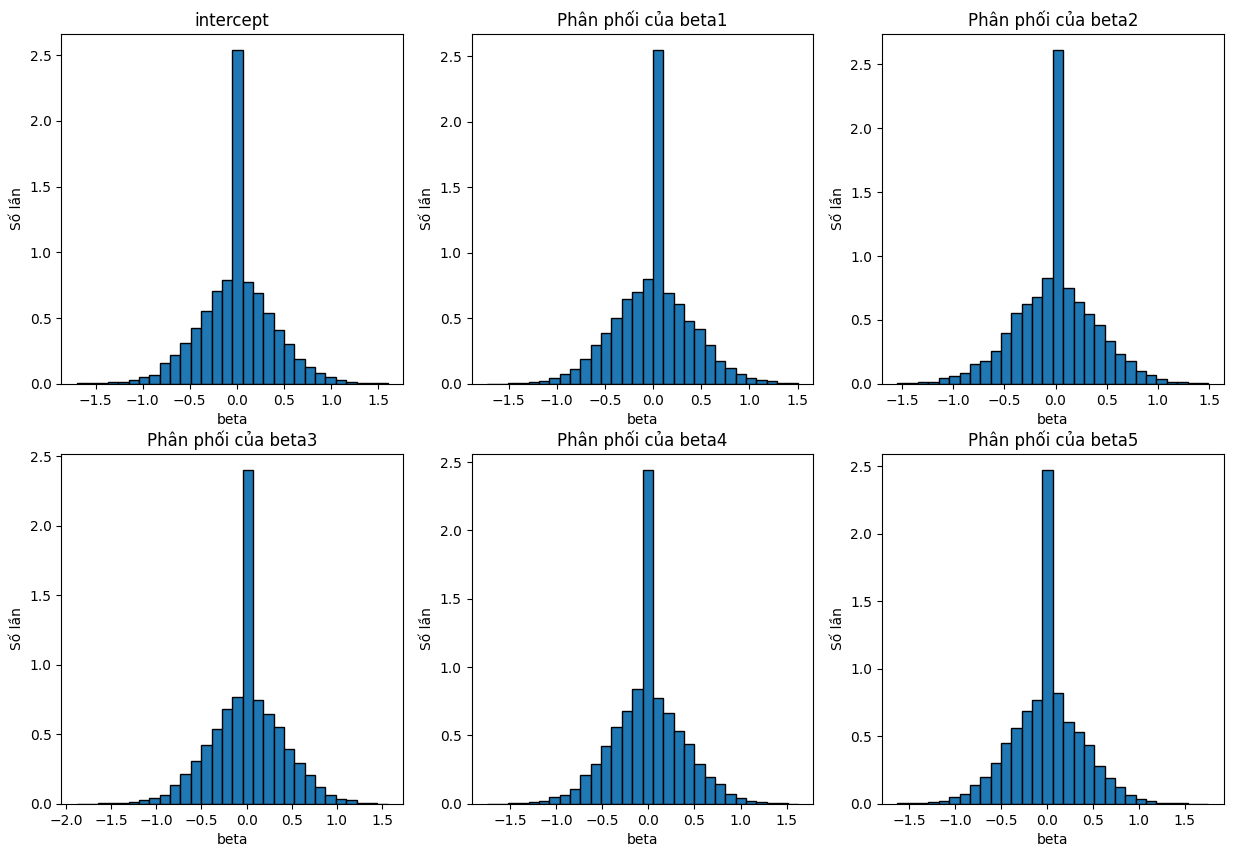

In [6]:
beta_df = pd.DataFrame(beta_hat_list)

fig, axes = plt.subplots(2, 3, figsize = (15, 10))
axes = axes.flatten()

for idx in range(6):
    axes[idx].hist(beta_df[idx], bins = 30, density = True,edgecolor = 'black')
    axes[idx].set_title(f'Phân phối của beta{idx}')
    axes[idx].set_xlabel('beta')
    axes[idx].set_ylabel('Số lần')
axes[0].set_title(f'intercept')

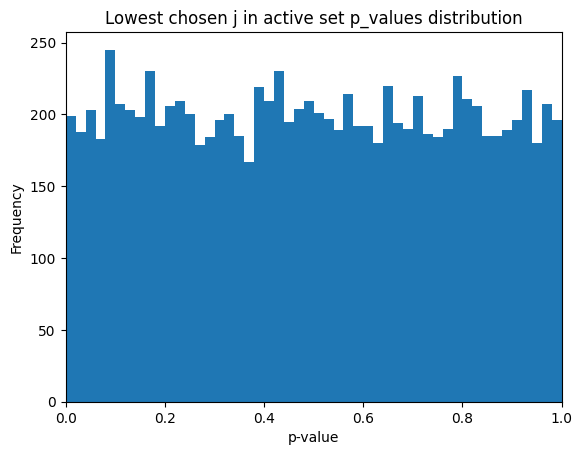

In [7]:


plt.figure()
plt.xlim(0, 1)
plt.hist(p_values_lists, bins = 50)
plt.title(f'Lowest chosen j in active set p_values distribution')
plt.xlabel(f'p-value')
plt.ylabel(f'Frequency')

plt.show()


In [8]:
p_values_list = np.array(p_values_lists)
print(np.max(p_values_list))
print(len(p_values_list))
print(np.sum(p_values_list > 0.8))
print(np.sum(p_values_list<0.2))
kstest(p_values_lists, 'uniform')

nan
10000
1972
2042


KstestResult(statistic=np.float64(nan), pvalue=np.float64(nan), statistic_location=np.float64(nan), statistic_sign=np.float64(nan))

In [9]:
print(p_values_lists)
print(type(p_value))

[0.5007706248815679, 0.6413262591775495, 0.5101347068734134, 0.40449297926037336, 0.2565671659555022, 0.13049696544355796, 0.2823250041039261, 0.8846950547936903, 0.23170625649996657, 0.4176313706250641, 0.16133191290948387, 0.6836408985338491, 0.11603650470660054, 0.3671547134416633, 0.48567178624857155, 0.947176406544445, 0.44988571821595247, 0.771420600434682, 0.04710232589792225, 0.35575768479661424, 0.05548332751482721, 0.5251921739836358, 0.7572268340118309, 0.6656759224352597, 0.9841279440852385, 0.6074782777413096, 0.9680327514321816, 0.21112585721376376, 0.5088921933584409, 0.9225074411202425, 0.9410033876924637, 0.8694255544062341, 0.07136104767617361, 0.002238214727214416, 0.9024323162514976, 0.5627396820829842, 0.7682681817762871, 0.4182457131338777, 0.7489044701668688, 0.48775236013212747, 0.193473784407816, 0.5069608900178058, 0.5909677618508997, 0.32354429525917183, 0.8663605882686434, 0.0952853391286248, 0.46351211222043665, 0.509611176989067, 0.3954582123276394, 0.1778